In [107]:
# Add module path for demo.
# Todo: make wheel file -> setup file -> pip install tsx-**.whl
import os
import sys
import pyts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch

from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries

WORK_DIR = ".."
NOTEBOOK_DIR = "."
DATA_DIR = f"{WORK_DIR}/tests/data"
assert os.path.exists(DATA_DIR), f"Not found folder {DATA_DIR}"
assert os.path.exists(WORK_DIR), f"Not found folder {WORK_DIR}"
assert os.path.exists(NOTEBOOK_DIR), f"Not found folder {NOTEBOOK_DIR}"

## Prepare Data Set

In [4]:
def load_data_set_bejin():
    data_link = f"{DATA_DIR}/pollution.csv"
    assert os.path.exists(data_link), f"Not found folder {data_link}"
    df = pd.read_csv(data_link)

    # Set date-time as index
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")

    return df

## LIME for Time Series

### Load data

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

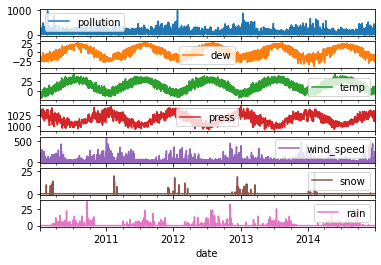

In [5]:
# Prepare data set
df = load_data_set_bejin()

# Encoding wind_direction to integer
encoder = LabelEncoder()
df["wind_direction"] = encoder.fit_transform(df["wind_direction"])

# Normalization
independents = ["dew", "temp", "press", "wind_direction", "wind_speed", "snow", "rain"]
dependent = "pollution"
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler.fit(df[independents].values)
y_scaler.fit(df[dependent].values.reshape(-1, 1))


In [200]:
# Global Init for matplotlib
# plt.tight_layout()

# Global param
n_steps = 128
window_size = 8
n_variables = len(independents)

In [ ]:
# Visualize the dataset 
df.loc[:, df.columns != 'wind_direction'].plot(subplots=True)

### Select randomly an instance of X from test-set

In [163]:
# 1- Load an instance
def get_instance_x(df, n_steps):
    start = np.random.randint(0, len(df.index) - n_steps - 1)
    end = start + n_steps
    x_df = df[start:end].copy()
    x_df = x_df.reset_index()
    x_df = x_df.loc[:, independents]
    return x_df

def plt_legend(fig, per_subplot=False):
    if per_subplot:
        # Plot all legends outside
        [ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) for ax in fig.axes]
        # [ax.legend(loc=1, bbox_to_anchor=(1.0, 0.5)) for ax in axes]

    # Or all legends into one
    else:
        #1 get all handles and labels of the fig.
        #2 use zip() -> group homonegous objects, ex: (Lines, Labels)
        #3 concatenate/flatten lists of lists -> list: 
        #   - ex: [[1,2, 3], [4, 5]] ­-> [1, 2, 3, 2, 3]
        #   - sum([[1,2,3]], []) do a trick 
        lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
        lines, labels = [sum(l, []) for l in zip(*lines_labels)]   
        fig.legend(lines, labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

def plt_hide_yticks(fig):
    for ax in fig.axes:
        ax.set_yticks([])

def plt_vlines(fig, n_steps=128, window_size=4, **kwargs):
    starts, ends, n_windows = pyts.utils.segmentation(n_steps, window_size, overlapping=False)
    vlines_pos = [0] + list(ends)   # vlines positions from 0
    for ax in fig.axes:
        ymin, ymax = ax.get_ylim()
        ax.vlines(vlines_pos, ymin=ymin, ymax=ymax, colors='r', ls=':')

# Plot segment-labels
def plt_segment_labels(fig, text_y=-0.10):
    starts, ends, n_windows = pyts.utils.segmentation(n_steps, window_size, overlapping=False)
    ax = fig.axes[-1]
    ax.text(-10, text_y, 'X\':')
    for i, p_x in enumerate(starts):
        # p_x = window_size * (i + 1)
        # text_x = p_x - (window_size / 2) # center
        text_x = p_x
        ax.text(text_x, text_y, r"$w_{%i}$" % i, c='r')

def plt_matrix(z_prime, ylabels=None, xlabels=None):
    n_variables = z_prime.shape[0]
    n_segments = z_prime.shape[1]

    fig, ax = plt.subplots()
    
    colors = ['gold', 'lightblue']
    cmap = LinearSegmentedColormap.from_list('', colors)
    # cm = 'GnBu'

    mat = ax.imshow(z_prime, cmap=cmap, interpolation='nearest')
    if not xlabels:
        xlabels = [r"$w_{%i}$" % i for i in range(n_segments)]
    if ylabels:
        plt.yticks(range(n_variables), ylabels)
    if xlabels:
        plt.xticks(range(n_segments), xlabels)
    plt.xticks(rotation=30)
    plt.xlabel('X\'')

    # this places 0 or 1 centered in the individual squares
    for y in range(n_variables):
        for x in range(n_segments):
            t = z_prime[y, x]
            ax.annotate(t, xy=(x, y), horizontalalignment='center', verticalalignment='center')

    # Plot legend
    # white as 1, on
    # black as 0, off -> perturbed segment
    legend_elements = [Patch(facecolor=color, edgecolor='w') for color in colors]

    ax.legend(loc='upper left',
              bbox_to_anchor=(1.0, 0.0, 1, 1),
              labels=["0: off", "1: on"],
              handles=legend_elements
              )


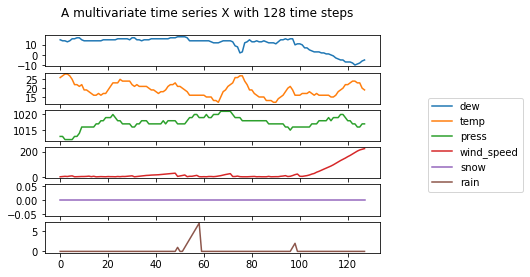

In [257]:
# Plot instance X
x = get_instance_x(df, n_steps)

x_mts = x.loc[:, x.columns != 'wind_direction']
title = f"A multivariate time series X with {n_steps} time steps"
x_mts.plot(subplots=True, legend=False, title=title)

fig = plt.gcf()
plt_legend(fig, per_subplot=False)

In [258]:
# Normalize data 
x[independents] = x_scaler.transform(x[independents].values)

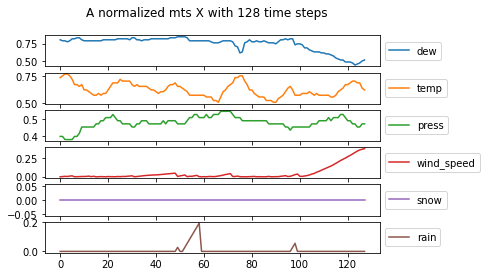

In [259]:
x_mts = x.loc[:, x.columns != 'wind_direction']
title = f"A normalized mts X with {n_steps} time steps"
x_mts.plot(subplots=True, legend=False, title=title)

fig = plt.gcf()
plt_legend(fig, per_subplot=True)
# plt.subplots_adjust(hspace=.0)

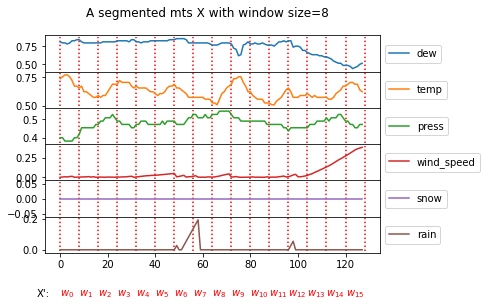

In [264]:
# X-segmented
window_size = 8

title = f"A segmented mts X with window size={window_size}"
x_mts.plot(subplots=True, legend=False, title=title)

fig = plt.gcf()
plt_legend(fig, per_subplot=True)

# Plot segment-lines
plt_vlines(fig, n_steps, window_size=window_size)
plt.subplots_adjust(hspace=.0)

plt_segment_labels(fig, -0.30)

### Predict Function or explaining models

In [265]:
# Prepare predict function
wavenet = tf.keras.models.load_model(f"{DATA_DIR}/wavenet_mts_128_1.h5")
lstm = tf.keras.models.load_model(f"{DATA_DIR}/lstm_mts_128_1.h5")

def predict_fn(z, model=lstm):
    z = z.reshape(1, 128, 7)
    z_hat = model.predict(z)
    z_hat = y_scaler.inverse_transform(z_hat.reshape(-1, 1))  # to avoid zero coef_ for z_hat in[0, 1]
    z_hat = z_hat.ravel()   # z_hat will arround 50 - 150
    return z_hat[0]

In [266]:
samples_size = 100
ts_x = x.values.reshape(n_variables, n_steps)
ts_lime = LIMETimeSeries(window_size=window_size, sample_size=samples_size)
ts_lime.explain(ts_x, predict_fn=predict_fn)

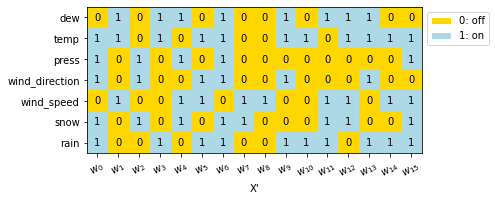

In [267]:
# Visualization Perturbation - Async and z_prime
z_prime, z, _, _ = ts_lime.get_a_local_sample()
plt_matrix(z_prime, ylabels=independents)

In [291]:
print(z_prime[0])
print(z[0, 0:16].round(3))
print(x.loc[0:16, 'dew'])


[0 1 0 1 1 0 1 0 0 1 0 1 1 1 0 0]
[0.    0.    0.    0.    0.    0.    0.    0.    0.754 0.4   1.    0.004
 0.    0.    0.794 0.77 ]
0     0.808824
1     0.794118
2     0.794118
3     0.779412
4     0.794118
5     0.823529
6     0.823529
7     0.838235
8     0.838235
9     0.808824
10    0.794118
11    0.794118
12    0.794118
13    0.794118
14    0.794118
15    0.794118
16    0.794118
Name: dew, dtype: float64


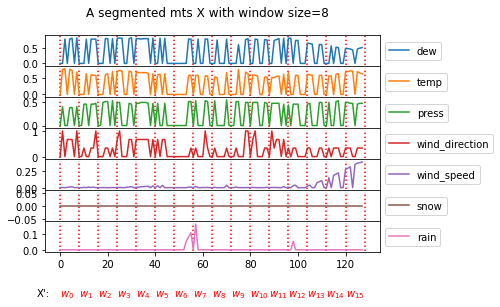

In [285]:
# Visualization Perturbation - Async and z
z_df = x.copy()
z_df[independents] = z.reshape(z_df[independents].values.shape)

z_df.plot(subplots=True, legend=False, title=title)

fig = plt.gcf()
plt_legend(fig, per_subplot=True)

# Plot segment-lines
plt_vlines(fig, n_steps, window_size=window_size)
plt.subplots_adjust(hspace=.0)

plt_segment_labels(fig, -0.30)

### Fitting the explaining model by using LIME Time Series

# Todo: mathematic here

A z_prime is multi-demnsional with shape of (n_features, n_segments). 

1 means keep it as original. 
0 will be perturbed and replaced by replacements_i (default is zero) of that corresponding segment


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

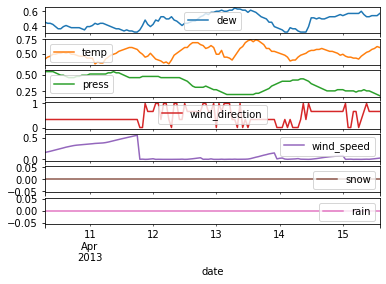

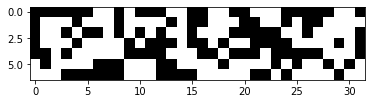

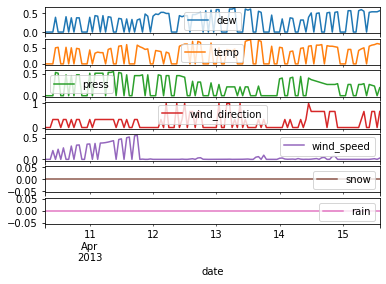

In [9]:
# An instance x
x[independents].plot(subplots=True)

# A z_prime
z_prime, z, z_hat, sample_weight = ts_lime.get_a_local_sample()
color_map = plt.cm.get_cmap('Greys').reversed()
plt.figure()
plt.imshow(z_prime, cmap=color_map)
# white as 1, on
# black as 0, off -> perturbed segment

# A z
z_df = x.copy()
z_df[independents] = z.reshape(z_df[independents].values.shape)
z_df[independents].plot(subplots=True)
# Notice of zero

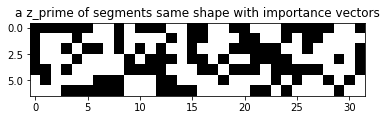

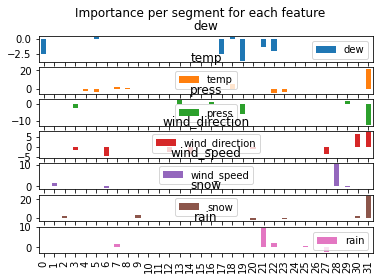

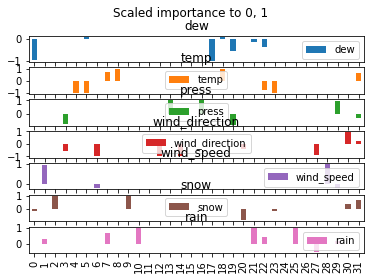

In [10]:
# Replot a z_prime 
plt.imshow(z_prime, cmap=color_map)
plt.title("a z_prime of segments same shape with importance vectors")

# Plot importance
ts_lime.plot_coef(feature_names=independents, title='Importance per segment for each feature')

# Plot importance and scale to 0 and 1 (per each feature)
from sklearn.preprocessing import Normalizer
ts_lime.plot_coef(feature_names=independents, scaler=Normalizer(), title='Scaled importance to 0, 1')

### Multiple run and average

In [11]:
instances = []
n_instances = 10
for i in range(n_instances):
    _x = get_instance_x(df)
    normalized_x = x_scaler.transform(_x[independents].values)
    ts_x = x[independents].values.reshape(7, 128)
    instances.append(ts_x)

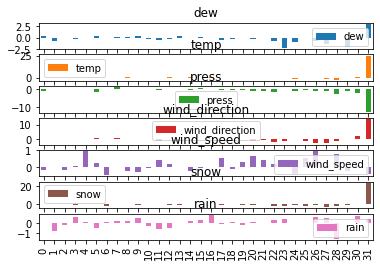

In [12]:
ts_lime = LIMETimeSeries(window_size=4, sample_size=100)
ts_lime.explain_instances(instances, predict_fn=predict_fn)
ts_lime.plot_coef(feature_names=independents)